In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/CNN dataset/'
!pip install openpyxl

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab
from skimage.morphology import disk, opening, dilation
import skimage.filters
import tensorflow as tf
import openpyxl
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [ ]:

# Define the Inception block
def inception_block(x, filters):
    # 1x1 Convolution
    conv1x1 = Conv2D(filters[0], (1, 1), activation=None, padding='same')(x)
    conv1x1 = Activation('relu')(conv1x1)

    # 3x3 Convolution
    conv3x3 = Conv2D(filters[1], (3, 3), activation=None, padding='same')(x)
    conv3x3 = Activation('relu')(conv3x3)

    # 5x5 Convolution
    conv5x5 = Conv2D(filters[2], (5, 5), activation=None, padding='same')(x)
    conv5x5 = Activation('relu')(conv5x5)

    # Pooling and Projection
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters[3], (1, 1), activation='relu', padding='same')(pool)

    # Concatenate all branches
    return concatenate([conv1x1, conv3x3, conv5x5, pool_proj])

# Define the model
def build_inception_model(input_shape, num_classes):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Initial convolution and pooling
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)

    # First Inception block
    x = inception_block(x, [32, 32, 32, 32])
    x = MaxPooling2D((2, 2))(x)

    # Second Inception block
    x = inception_block(x, [64, 64, 64, 64])
    x = MaxPooling2D((2, 2))(x)

    # Third Inception block
    x = inception_block(x, [64, 64, 64, 64])
    x = MaxPooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model




In [ ]:

# Parameters
# dates = ["8_18", "9_02", "9_09", "9_20"]
dates = ["9_09"]
# img_sizes = [32, 64, 128]
img_sizes = [128]
input_shape = (128, 128, 3)
num_classes = 4
epochs = 10

# Process data and train the model
for date in dates:
    for img_size in img_sizes:
        # Load the data
        data = np.load(f'{folder_path}/twri_rgb_6832_cotton_{img_size}x{img_size}_{date}.npy')
        # Load the labels from an Excel file
        labels = pd.read_excel(f'{folder_path}/labels_rgb.xlsx')

        y_label = labels['class'].values

        # Remove the filler type
        valid_indices = y_label != 0
        data = data[valid_indices]
        y_label = y_label[valid_indices] - 1

        # Morphology image processing to keep cotton only
        for i in range(len(data)):
            image = data[i] / 255.0
            gray_image = rgb2lab(image)[:, :, 1]
            val = skimage.filters.threshold_otsu(gray_image)
            mask = gray_image > val
            mask = opening(mask, disk(2))
            mask = dilation(mask, disk(1))
            image[mask] = 0
            data[i] = image

        # Split the data and normalization
        train_images, test_images, train_labels, test_labels = train_test_split(
            data, y_label, test_size=0.3, random_state=42)

In [ ]:
# Build and summarize the model
input_shape = (128, 128, 3)  # Example input shape
num_classes = 4              # Number of output classes
model = build_inception_model(input_shape, num_classes)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 32)     │          1,056 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │         25,632 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ max_pooling2d[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 64, 32)     │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 32)     │          1,056 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 128)    │              0 │ activation[0][0],      │
│                           │                        │                │ activation_1[0][0],    │
│                           │                        │                │ activation_2[0][0],    │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │          8,256 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 64)     │         73,792 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 64)     │        204,864 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3      

 Total params: 3,020,932 (11.52 MB)

 Trainable params: 3,020,932 (11.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, epochs=15,
                        validation_data=(test_images, test_labels))

Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 608s 5s/step - accuracy: 0.4142 - loss: 1.2591 - val_accuracy: 0.5090 - val_loss: 1.0275
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 573s 5s/step - accuracy: 0.6337 - loss: 0.8126 - val_accuracy: 0.5499 - val_loss: 1.0609
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 617s 5s/step - accuracy: 0.6405 - loss: 0.7758 - val_accuracy: 0.7111 - val_loss: 0.6498
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 625s 5s/step - accuracy: 0.7033 - loss: 0.6741 - val_accuracy: 0.7111 - val_loss: 0.6315
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 570s 5s/step - accuracy: 0.7286 - loss: 0.6174 - val_accuracy: 0.7092 - val_loss: 0.6785
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 646s 5s/step - accuracy: 0.7584 - loss: 0.5697 - val_accuracy: 0.7142 - val_loss: 0.6755
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 601s 5s/step - accuracy: 0.7962 - loss: 0.4814 - val_accuracy: 0.7254 - val_loss: 0.6579
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 595s 5s/step - accuracy: 0.8410 - loss: 0.4021 - val_accu

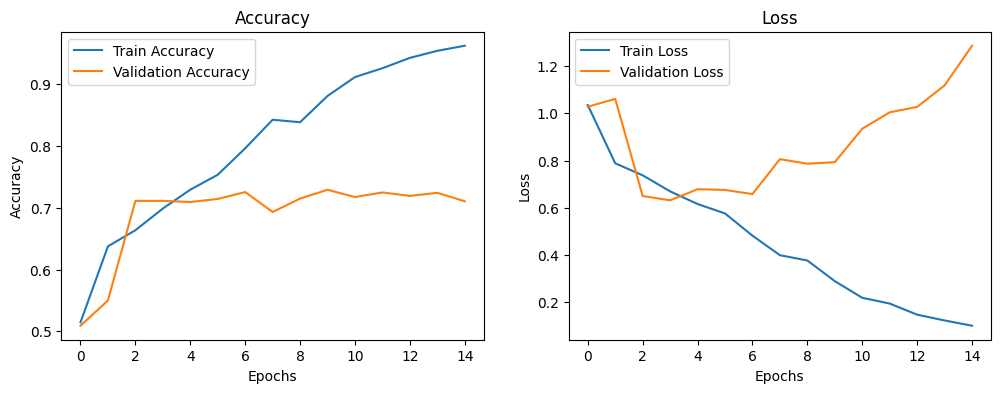

In [ ]:
# Plot training & validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the plotting function
plot_training_history(history)


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")

51/51 - 54s - 1s/step - accuracy: 0.7105 - loss: 1.2857
Test accuracy: 0.710477352142334
